## Importando bibliotecas e base

In [69]:
from warnings import filterwarnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import TunedThresholdClassifierCV
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, f1_score, make_scorer, accuracy_score, precision_score, recall_score, auc
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from category_encoders import TargetEncoder
from feature_engine.encoding import WoEEncoder, DecisionTreeEncoder
from category_encoders.woe import WOEEncoder
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif
import sys
sys.path.append(r'/home/jean/projetos/pod-bank/global/')
from util import *
import joblib
from sklearn.ensemble import HistGradientBoostingClassifier
from lightgbm import LGBMClassifier
import pickle

filterwarnings('ignore')
pd.set_option('display.max_columns', None)

## Lendo os dados

In [70]:
df_treino_full = pd.read_parquet('../data/abt/abt_train', engine='fastparquet')

In [71]:
df_treino_full.shape

(215257, 552)

### Aplicando primeira feature selection

In [72]:

with open('../artifacts/prd_first_list_features.pkl', 'rb') as f:
    colunas_finais = pickle.load(f)

In [73]:
df_treino_full = df_treino_full[colunas_finais]
df_treino_full.shape

(215257, 161)

In [74]:
# Filtra as colunas que NÃO começam com "var_"
cols_to_keep_train = [col for col in df_treino_full.columns if col.startswith('var_')]

In [75]:
# Salva a remoção de variáveis na pasta artifacts
with open('../artifacts/prd_cols_to_keep_skl.pkl', 'wb') as f:
  pickle.dump(cols_to_keep_train, f)

In [76]:
len(cols_to_keep_train)

50

In [ ]:

with open('../artifacts/prd_cols_to_keep_skl.pkl', 'rb') as f:
    cols_to_keep_train = pickle.load(f)

In [77]:
df_treino_full = df_treino_full.drop(columns=cols_to_keep_train)
df_treino_full.shape

(215257, 111)

## Houldout Out-Of-Sample

In [79]:
# Separando as variáveis de entrada (features) e de saída (target)
X = df_treino_full.drop(columns=['TARGET','SK_ID_CURR'])
y = df_treino_full["TARGET"]

In [80]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42)
X_train.shape,X_test.shape

((150679, 109), (64578, 109))

In [81]:
metadados = generate_metadata(df=X_train, targets=['TARGET'], orderby='PC_NULOS')
metadados

,FEATURE,USO_FEATURE,QT_NULOS,PC_NULOS,CARDINALIDADE,TIPO_FEATURE
0,COMMONAREA_MODE,Explicativa,105347,69.91,2682,float64
1,QT_MAX_QT_MAX_DAYS_ENTRY_PAYMENT_U3M_INSTALLME...,Explicativa,104794,69.55,190,float64
2,VL_MED_VL_TOT_AMT_PAYMENT_U3M_INSTALLMENTS_U12...,Explicativa,104794,69.55,40714,float64
3,QT_MAX_QT_MIN_DAYS_ENTRY_PAYMENT_U3M_INSTALLME...,Explicativa,104794,69.55,236,float64
4,NONLIVINGAPARTMENTS_AVG,Explicativa,104712,69.49,322,float64
...,...,...,...,...,...,...
104,NAME_HOUSING_TYPE,Explicativa,0,0.00,6,object
105,WEEKDAY_APPR_PROCESS_START,Explicativa,0,0.00,7,object
106,FLAG_OWN_CAR,Explicativa,0,0.00,2,object
107,CODE_GENDER,Explicativa,0,0.00,3,object


## Dataprep e Feature Selection

In [83]:
from sklearn.preprocessing import OneHotEncoder


cat_features_low_card = metadados[(metadados['TIPO_FEATURE'] == 'object') & 
                                (metadados['CARDINALIDADE'] < 20)]['FEATURE'].tolist()

cat_features_high_card = metadados[(metadados['TIPO_FEATURE'] == 'object') & 
                                 (metadados['CARDINALIDADE'] >= 20)]['FEATURE'].tolist()

num_features = metadados[(metadados['TIPO_FEATURE'] != 'object')]['FEATURE'].tolist()

# Definir pipelines separados para cada tipo de feature categórica
cat_pipe_low = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

cat_pipe_high = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('target_enc', TargetEncoder())
])

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

# Combinar todos os pipelines
preprocessor = ColumnTransformer([
    ('cat_low', cat_pipe_low, cat_features_low_card),
    ('cat_high', cat_pipe_high, cat_features_high_card),
    ('num', num_pipe, num_features)
])

preprocesssor = Pipeline(steps=[("preprocessor", preprocessor)])

# Aplicar o pré-processamento
X_train_processed = preprocesssor.fit_transform(X_train, y_train)
X_test_processed = preprocesssor.transform(X_test)

# Para obter os nomes das colunas após o OneHotEncoder
# (isso é mais complexo pois o OneHotEncoder cria múltiplas colunas)
onehot_columns = []
if len(cat_features_low_card) > 0:
    onehot = preprocesssor.named_steps['preprocessor'].named_transformers_['cat_low'].named_steps['onehot']
    for i, col in enumerate(cat_features_low_card):
        cats = onehot.categories_[i]
        onehot_columns.extend([f"{col}_{cat}" for cat in cats])

# Nomes finais das colunas
processed_columns = onehot_columns + cat_features_high_card + num_features

# Converter para DataFrame
X_train_processed = pd.DataFrame(X_train_processed, columns=processed_columns)
X_test_processed = pd.DataFrame(X_test_processed, columns=processed_columns)

In [13]:
metadados = generate_metadata(df=X_train_processed, targets=['TARGET'], orderby='CARDINALIDADE')
metadados

,FEATURE,USO_FEATURE,QT_NULOS,PC_NULOS,CARDINALIDADE,TIPO_FEATURE
0,VL_TOT_AMT_CREDIT_SUM_CRED_ACT_CLD_BUREAU,Explicativa,0,0.0,88633,float64
1,EXT_SOURCE_2,Explicativa,0,0.0,84893,float64
2,EXT_SOURCE_1,Explicativa,0,0.0,60604,float64
3,VL_MED_AMT_CREDIT_SUM_DEBT_U9M_BUREAU,Explicativa,0,0.0,42068,float64
4,VL_MED_VL_TOT_AMT_PAYMENT_U3M_INSTALLMENTS_U12...,Explicativa,0,0.0,40714,float64
...,...,...,...,...,...,...
157,FLAG_WORK_PHONE,Explicativa,0,0.0,2,float64
158,FLAG_EMAIL,Explicativa,0,0.0,2,float64
159,REG_REGION_NOT_WORK_REGION,Explicativa,0,0.0,2,float64
160,QT_MAX_NFLAG_LAST_APPL_IN_DAY_U12M_PREV_APP,Explicativa,0,0.0,1,float64


In [14]:
# Salva o pipeline na pasta artifacts
with open('../artifacts/prd_preprocesssor_skl.pkl', 'wb') as f:
  pickle.dump(preprocesssor, f)

## Feature Selection

In [15]:
#X_train_transformed = X_train_processed

In [16]:
clf = RandomForestClassifier(random_state=0, max_depth=5, min_samples_leaf=2)

In [17]:
clf.fit(X_train_processed, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Número de features selecionadas:  10


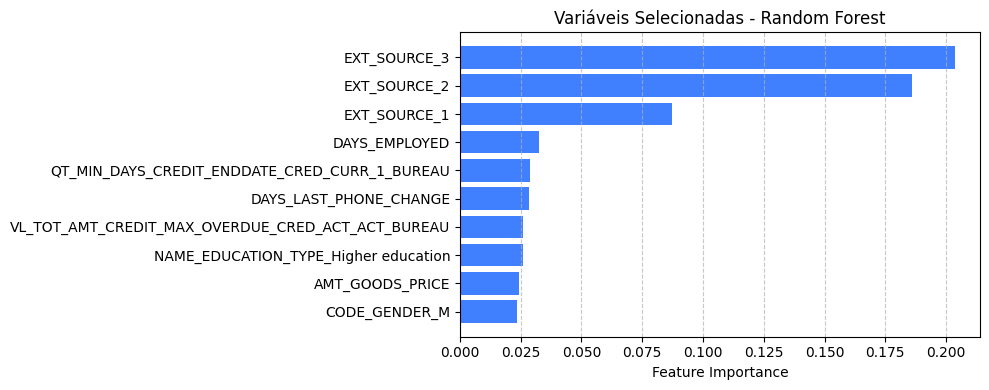

In [18]:
#Obtendo o feature importance
feature_importances = clf.feature_importances_
features = pd.DataFrame({
    'Feature': X_train_processed.columns,
    'Importance': feature_importances
})

#Ordenar vars por importância
features = features.sort_values(by='Importance', ascending=False)

#Estabelecendo um ponto de corte
cutoff_maximp = 0.11

cutoff = cutoff_maximp * feature_importances.max()

# Selecionando vars acima do ponto de corte
selected_features = X_train_processed.columns[feature_importances > cutoff].tolist()
print('Número de features selecionadas: ', len(selected_features))

#Ordenar vars por importância
features = features.sort_values(by='Importance', ascending=True)

# Filtrar o DataFrame para apenas as features acima do corte
selected_features_df = features[features['Importance'] > cutoff]

# Ajusta o tamanho da figura com base no número de features selecionadas
plt.figure(figsize=(10, len(selected_features_df)*0.4))

# Plota as features selecionadas
plt.barh(selected_features_df['Feature'], selected_features_df['Importance'], color=(0.25, 0.5, 1))
plt.xlabel("Feature Importance")
plt.title("Variáveis Selecionadas - Random Forest")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [19]:
# Salva as features selecionadas na pasta artifacts
with open('../artifacts/prd_selected_features_skl.pkl', 'wb') as f:
  pickle.dump(selected_features, f)

## Testar algoritmos

In [20]:
algoritmos = [
    DecisionTreeClassifier(criterion='gini', random_state=0, max_depth=7, min_samples_leaf=3),
    RandomForestClassifier(random_state=0, max_depth=7, min_samples_leaf=3),
    GradientBoostingClassifier(random_state=0, max_depth=7, min_samples_leaf=3),
    LGBMClassifier(random_state=0, max_depth=7, min_child_samples=3, n_jobs=-1, verbosity=-1,)  # LightGBM
]

for algoritmo in algoritmos:

    nome_algoritmo = str(algoritmo)[:str(algoritmo).find("(")]
    # Treino do modelo
    algoritmo.fit(X_train_processed[selected_features],y_train)

    # Avaliar modelo
    metricas = calculate_metrics_models_classifier(nome_algoritmo,algoritmo, X_train_processed[selected_features], y_train, X_test_processed[selected_features], y_test)
    display(metricas)



,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,DecisionTreeClassifier,Treino,0.920102,0.641762,0.027488,0.728706,0.457412,0.335105
1,DecisionTreeClassifier,Teste,0.918889,0.463687,0.015885,0.711646,0.423293,0.323385


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,RandomForestClassifier,Treino,0.919259,1.0,0.001723,0.748986,0.497971,0.364847
1,RandomForestClassifier,Teste,0.919090,0.5,0.000191,0.733419,0.466839,0.348745


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,GradientBoostingClassifier,Treino,0.924429,0.955581,0.068844,0.813524,0.627049,0.467484
1,GradientBoostingClassifier,Teste,0.918951,0.477387,0.018182,0.739154,0.478309,0.358369


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,LGBMClassifier,Treino,0.920420,0.814103,0.020842,0.787109,0.574217,0.427982
1,LGBMClassifier,Teste,0.919198,0.530973,0.011483,0.741521,0.483043,0.363051


## Tunagem de hiperparâmetros

In [21]:
import optuna

OPTUNA_EARLY_STOPING = 10

class EarlyStoppingExceeded(optuna.exceptions.OptunaError):
    early_stop = OPTUNA_EARLY_STOPING
    early_stop_count = 0
    best_score = None

def early_stopping_opt(study, trial):
    if EarlyStoppingExceeded.best_score == None:
      EarlyStoppingExceeded.best_score = study.best_value

    if study.best_value < EarlyStoppingExceeded.best_score:
        EarlyStoppingExceeded.best_score = study.best_value
        EarlyStoppingExceeded.early_stop_count = 0
    else:
      if EarlyStoppingExceeded.early_stop_count > EarlyStoppingExceeded.early_stop:
            EarlyStoppingExceeded.early_stop_count = 0
            best_score = None
            raise EarlyStoppingExceeded()
      else:
            EarlyStoppingExceeded.early_stop_count=EarlyStoppingExceeded.early_stop_count+1
    #print(f'EarlyStop counter: {EarlyStoppingExceeded.early_stop_count}, Best score: {study.best_value} and {EarlyStoppingExceeded.best_score}')
    return

In [22]:
# Definir CV
from sklearn.model_selection import StratifiedKFold, cross_val_score


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Objetiva do Optuna
def objective(trial):
    params = {
        # Hiperparâmetros básicos
        'n_estimators': trial.suggest_int('n_estimators', 5, 50),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        
        # Regularização
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        
        # Amostragem
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        
        # Balanceamento de classes
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 2, 10),
        
        # Tipo de boosting
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        
        # Fixos
        "metric": "auc",
        'objective': 'binary',
        'verbosity': -1,
        'random_state': 42
    }


    model = LGBMClassifier(**params)

    # cross_val_score retorna uma lista com a métrica para cada fold
    scores = cross_val_score(model, X_train_processed[selected_features], y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
    
    # Média dos AUCs
    return np.mean(scores)

# Estudo
study = optuna.create_study(direction="maximize",study_name="modelo", storage="sqlite:///modelo.db")
study.add_trials(study.trials)
try:
    study.optimize(objective, n_trials=50, timeout=600, callbacks=[early_stopping_opt])

except EarlyStoppingExceeded:
    print(f'EarlyStopping Exceeded: No new best scores on iters {OPTUNA_EARLY_STOPING}')

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-07-24 13:22:39,503] A new study created in RDB with name: modelo
[I 2025-07-24 13:23:33,597] Trial 0 finished with value: 0.7380863673420264 and parameters: {'n_estimators': 40, 'learning_rate': 0.20198675168409885, 'max_depth': 5, 'num_leaves': 44, 'reg_alpha': 0.4100443759577046, 'reg_lambda': 0.05076490023170954, 'subsample': 0.6152902268728411, 'colsample_bytree': 0.7788443030527674, 'scale_pos_weight': 7.97740490854124, 'boosting_type': 'dart'}. Best is trial 0 with value: 0.7380863673420264.
[I 2025-07-24 13:24:31,552] Trial 1 finished with value: 0.7357915482042682 and parameters: {'n_estimators': 48, 'learning_rate': 0.06506806227048209, 'max_depth': 7, 'num_leaves': 51, 'reg_alpha': 0.23604160282840625, 'reg_lambda': 0.9611817964481518, 'subsample': 0.8957797719632163, 'colsample_bytree': 0.7888015912898836, 'scale_pos_weight': 9.243441249521055, 'boosting_type': 'dart'}. Best is trial 0 with value: 0.7380863673420264.
[I 2025-07-24 13:24:35,739] Trial 2 finished with 

EarlyStopping Exceeded: No new best scores on iters 10
Number of finished trials: 12
Best trial:
  Value: 0.7380863673420264
  Params: 
    n_estimators: 40
    learning_rate: 0.20198675168409885
    max_depth: 5
    num_leaves: 44
    reg_alpha: 0.4100443759577046
    reg_lambda: 0.05076490023170954
    subsample: 0.6152902268728411
    colsample_bytree: 0.7788443030527674
    scale_pos_weight: 7.97740490854124
    boosting_type: dart


In [23]:
algoritmo = LGBMClassifier(**study.best_params,random_state = 0)

nome_algoritmo = str(algoritmo)[:str(algoritmo).find("(")]
    # Treino do modelo
algoritmo.fit(X_train_processed[selected_features],y_train)

    # Avaliar modelo
metricas = calculate_metrics_models_classifier(nome_algoritmo,algoritmo, X_train_processed[selected_features], y_train, X_test_processed[selected_features], y_test)
display(metricas)

,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,LGBMClassifier,Treino,0.799362,0.205253,0.515549,0.757187,0.514373,0.382903
1,LGBMClassifier,Teste,0.798987,0.200124,0.495311,0.738755,0.477510,0.356722


## Ordenação nos decis

### Treino

In [35]:
y_train.index = X_train_processed.index

bins = 16
tab = pd.concat([X_train_processed[selected_features],y_train],axis=1).copy()
tab['score'] = algoritmo.predict_proba(tab.drop(columns=['TARGET']))[:,0]
tab['decile'] = pd.qcut(tab['score'], bins, labels=False)

# Criar tabela detalhada
table = tab.groupby('decile').agg(
    min_score=pd.NamedAgg(column='score', aggfunc='min'),
    max_score=pd.NamedAgg(column='score', aggfunc='max'),
    event_rate=pd.NamedAgg(column='TARGET', aggfunc='mean'),
    volume=pd.NamedAgg(column='TARGET', aggfunc='size'),
    qt_bads=pd.NamedAgg(column='TARGET', aggfunc=lambda x: (x == 1).sum()),
    perc_total_bads=pd.NamedAgg(column='TARGET', aggfunc=lambda x: (x == 1).sum()/tab[tab.TARGET == 1].shape[0])
).reset_index()
table['min_score'] = 1000*table['min_score']
table['max_score'] = 1000*table['max_score']
table_train = table[['decile','event_rate','perc_total_bads', 'volume']]
table_train.rename(columns={'event_rate':'event_rate_train','perc_total_bads':'perc_total_bads_train', 'volume': 'volume_train'},inplace=True)
table_train

,decile,event_rate_train,perc_total_bads_train,volume_train
0,0,0.306010,0.236481,9418
1,1,0.185728,0.143514,9417
2,2,0.146634,0.113317,9418
3,3,0.119146,0.092065,9417
4,4,0.100881,0.077952,9417
5,5,0.078254,0.060474,9418
6,6,0.072316,0.055879,9417
7,7,0.053196,0.041109,9418
8,8,0.052034,0.040207,9417
9,9,0.045874,0.035448,9417


### Teste

In [36]:
y_test.index = X_test_processed.index

bins = 16
tab = pd.concat([X_test_processed[selected_features],y_test],axis=1).copy()
tab['score'] = algoritmo.predict_proba(tab.drop(columns=['TARGET']))[:,0]
tab['decile'] = pd.qcut(tab['score'], bins, labels=False)

# Criar tabela detalhada
table = tab.groupby('decile').agg(
    min_score=pd.NamedAgg(column='score', aggfunc='min'),
    max_score=pd.NamedAgg(column='score', aggfunc='max'),
    event_rate=pd.NamedAgg(column='TARGET', aggfunc='mean'),
    volume=pd.NamedAgg(column='TARGET', aggfunc='size'),
    qt_bads=pd.NamedAgg(column='TARGET', aggfunc=lambda x: (x == 1).sum()),
    perc_total_bads=pd.NamedAgg(column='TARGET', aggfunc=lambda x: (x == 1).sum()/tab[tab.TARGET == 1].shape[0])
).reset_index()
table['min_score'] = 1000*table['min_score']
table['max_score'] = 1000*table['max_score']
table_test = table[['decile','event_rate','perc_total_bads', 'volume']]
table_test.rename(columns={'event_rate':'event_rate_test','perc_total_bads':'perc_total_bads_test', 'volume':'volume_test'},inplace=True)
table_test

,decile,event_rate_test,perc_total_bads_test,volume_test
0,0,0.291305,0.225072,4037
1,1,0.181615,0.140287,4036
2,2,0.144266,0.111962,4055
3,3,0.113020,0.086890,4017
4,4,0.093905,0.072536,4036
5,5,0.082260,0.063541,4036
6,6,0.067146,0.051866,4036
7,7,0.058474,0.045167,4036
8,8,0.054509,0.042105,4036
9,9,0.045590,0.035215,4036


In [37]:
summary = pd.merge(table_train,table_test,on='decile',how='inner')
summary

,decile,event_rate_train,perc_total_bads_train,volume_train,event_rate_test,perc_total_bads_test,volume_test
0,0,0.306010,0.236481,9418,0.291305,0.225072,4037
1,1,0.185728,0.143514,9417,0.181615,0.140287,4036
2,2,0.146634,0.113317,9418,0.144266,0.111962,4055
3,3,0.119146,0.092065,9417,0.113020,0.086890,4017
4,4,0.100881,0.077952,9417,0.093905,0.072536,4036
5,5,0.078254,0.060474,9418,0.082260,0.063541,4036
6,6,0.072316,0.055879,9417,0.067146,0.051866,4036
7,7,0.053196,0.041109,9418,0.058474,0.045167,4036
8,8,0.052034,0.040207,9417,0.054509,0.042105,4036
9,9,0.045874,0.035448,9417,0.045590,0.035215,4036


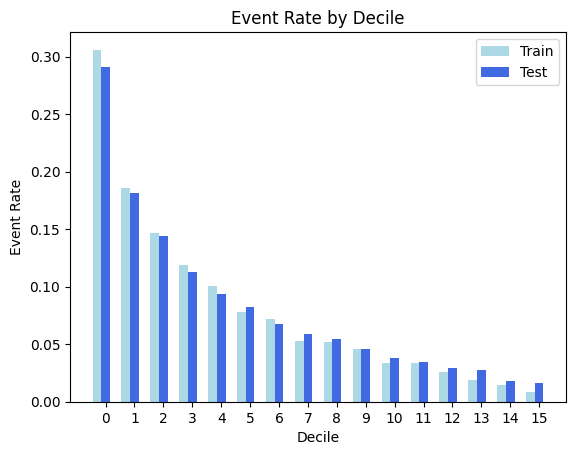

In [38]:
# Plotando o gráfico de barras para Event Rate por Decil
barWidth = 0.3
r1 = np.arange(len(summary))
r2 = [x + barWidth for x in r1]

plt.bar(r1, summary['event_rate_train'], color='lightblue', width=barWidth, label='Train')
plt.bar(r2, summary['event_rate_test'], color='royalblue', width=barWidth, label='Test')

plt.xlabel('Decile')
plt.ylabel('Event Rate')
plt.title('Event Rate by Decile')
plt.xticks([r + barWidth for r in range(len(summary))], summary['decile'])
plt.legend()
plt.show()

In [33]:
with open('../artifacts/modelo_lgbm_skl.pkl', 'wb') as file:
  pickle.dump(algoritmo, file)